# Final Notebook
### Model of home sale price indicators in King County.



## Contents
- Notebook Summary
- Library and data importing
- EDA
- Data Processing
- Create Baseline Model
- Perform multiple model iterations
- Draw conclusions from final model

# Notebook Summary

This notebook provides a high level summary of the process we undertook to achieve the project task. Our task was to create a linear regression model in order to draw insights on what influences home sale price in King County. Our project audience was potential homebuyers. King County offers available homes at a wide range of prices. We decided to taylor our analysis towards the average home buyer and wanted to reveal what home features influenced home price and by how much. In order to accomplish this task, we utilized data available from [King County Department of Assessments](https://info.kingcounty.gov/assessor/DataDownload/default.aspx). Specifically, we gathered information on property sales, residential building features, and parcel features from the Real Property Sales, Residential Buildings, and Parcel datasets. Documentation for these datasets are available from the data source as well. 

Our initial analysis wanted to explore the effects having a porch, being on the waterfront, and the present of nuisances (traffic noise, powerlines, etc) had on home sale price. In addition to that, we also explored what influence the size, quality, and location of a home had on it's respective sale price.

This notebook will walk through our process of data gathering and exploration, how we processed and analyzed this data, as well as the results of the analysis.

## Data Importing

The following cell allows us to import functions written in our .py files. All of which can be found under the src/ directory of this repo.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import src.mc_functions as mc
import src.jw_total_df as jw

We will begin by importing the data into a pandas dataframe. The function create_dataframe selects the columns from the three datasets we need for our analysis which are as follows.

Property Sales:
- Major
- Minor
- Sale Price

Residential Buildings:
- Major
- Minor
- SqFtTotLiving
- SqFtOpenPorch
- SqFtEnclosedPorch
- BldgGrade
- Bedrooms
- BathFullCount
- BathHalfCount
- SqFtGarageAttached
- NbrLivingUnits

Parcel:
- Major
- Minor
- TrafficNoise
- PowerLines
- OtherNuisances
- TidelandShoreland
- Township
- SqFtLot
- LakeWashington
- WfntLocation

The function join's the columns from these three dataframes on the 'Major' and 'Minor columns which are the unique identifiers of the observations. Our analysis was done specifically on property sales from 2019 so our function filters the resulting dataframe to only include information from that year. It also creates two extra columns 'has_porch' and 'on_water' which indicate whether or not the home has a porch and is on the waterfront


In [5]:
df = mc.create_dataframe()

The dataframe is now imported and stored in variable df. Now we can look at a few rows and make sure all the data looks correct.

In [6]:
df.head()

,Major,Minor,SalePrice,PropertyClass,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,BldgGrade,Bedrooms,BathFullCount,...,TrafficNoise,PowerLines,OtherNuisances,TidelandShoreland,Township,SqFtLot,WfntLocation,WfntAccessRights,has_porch,on_water
0,213043,0120,560000,8,1930,180,0,7,3,2,...,0,0,0,0,26,10523,0,N,1,0
1,940652,0630,435000,8,1975,45,0,7,3,1,...,0,0,0,0,22,7392,0,N,1,0
2,937630,0695,550000,8,1560,0,0,8,2,1,...,0,0,0,0,25,2500,0,N,0,0
3,098400,0450,409950,8,1850,0,0,7,3,2,...,0,0,0,0,23,7875,0,N,0,0
4,030200,0645,380000,8,1750,670,0,7,4,1,...,0,0,0,0,21,45303,0,N,1,0


Now we can check the datatypes of each variable and whether we have any missing data or not.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43838 entries, 0 to 43837
Data columns (total 21 columns):
Major                43838 non-null object
Minor                43838 non-null object
SalePrice            43838 non-null int64
PropertyClass        43838 non-null int64
SqFtTotLiving        43838 non-null int64
SqFtOpenPorch        43838 non-null int64
SqFtEnclosedPorch    43838 non-null int64
BldgGrade            43838 non-null int64
Bedrooms             43838 non-null int64
BathFullCount        43838 non-null int64
BathHalfCount        43838 non-null int64
TrafficNoise         43838 non-null int64
PowerLines           43838 non-null int64
OtherNuisances       43838 non-null int64
TidelandShoreland    43838 non-null int64
Township             43838 non-null int64
SqFtLot              43838 non-null int64
WfntLocation         43838 non-null int64
WfntAccessRights     43838 non-null object
has_porch            43838 non-null int64
on_water             43838 non-null int64
dtypes

It looks like all the rows are numeric except for three. Also we have no missing data. One thing to notice from the dataframe sample above is that 'SalePrice' has a row with a zero value. This may confuse our model so we will remove all rows that have a sale price of zero

In [7]:
df = df[df['SalePrice'] > 0]

Now we can check the distribution of 'SalePrice' to check for potential outliers. To do this we will use the predefined function 'plot_dist' which creates a seaborn distplot and boxplot of the variable passed in.

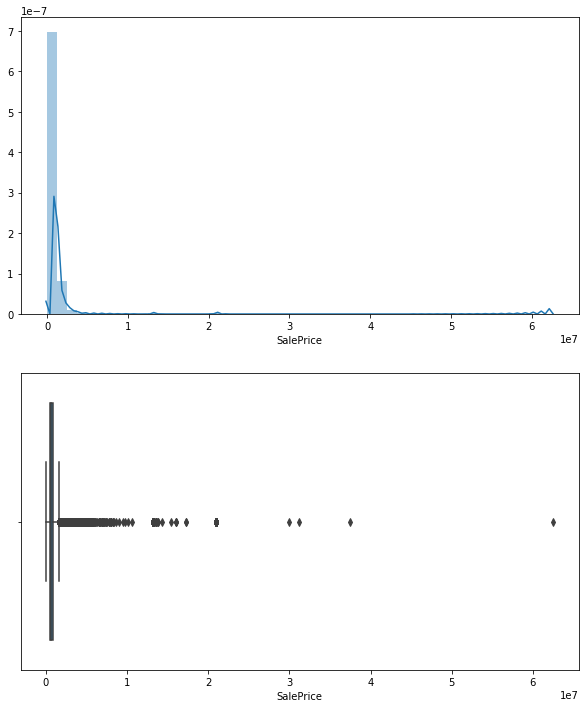

In [7]:
mc.plot_dist(df['SalePrice'])

Both plots show an extremely positive skew and the boxplot indicates there are many extreme outliers. We will need to remove those and try and make this resemble a near normal distribution in order to get the best results from our model. To remove these outliers we will use z-scores. We will consider an outlier to be any value more than 2.5 standard deviations from the mean in any direction. First we will find the z-score of every 'SalePrice' in our dataframe and store it in the list z-score. We will use the z-score function defined in the .py file. First we need to find the mean and standard deviation of 'SalePrice'.

In [8]:
# mean of sale price
mean_sale_price = df['SalePrice'].mean()
# Standard deviation of sale price
std_sale_price = df['SalePrice'].std()

We can now use these values to find the z-score of every sale price value.

In [9]:
z_scores = [mc.z_score(p, mean_sale_price, std_sale_price)
            for p in df['SalePrice']]

Now using this z_scores list, we can create a mask that will filter the dataframe for outliers. The mask will hold a value of 'False' if the z_score is more than 2.5 standard deviations from the mean and 'True' otherwise. This mask will remove the rows from the dataframe that holds a value of 'False'.

In [10]:
outliers = [False if ((z < -2.5) | (z > 2.5)) else True for z in z_scores]
df = df[outliers]

Now that we have removed some outliers we can check the distribution again.

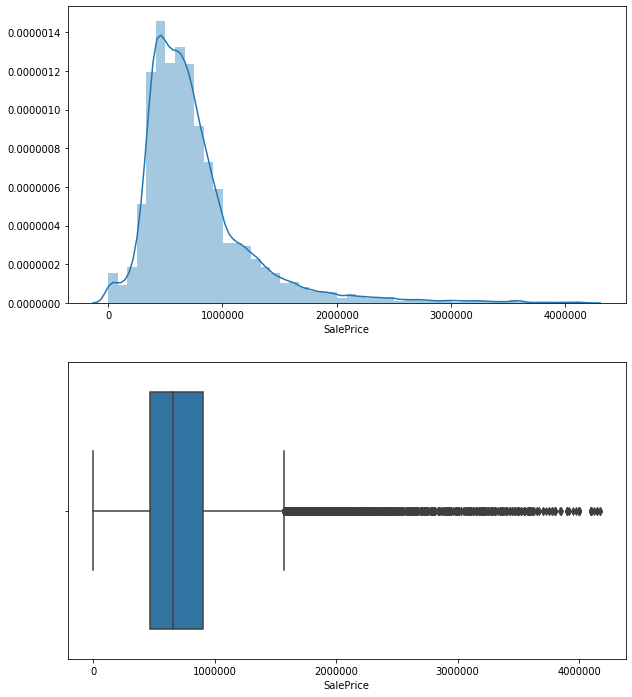

In [11]:
mc.plot_dist(df['SalePrice'])

That distribution looks much better. The mask removed all rows with a 'SalePrice' value above about 4 million. More may need to be removed later, but for now this is good. Now that outliers are removed, we can begin to explore the correlation between home sale price and different home features. We will do this by creating a correlation matrix and a heatmap of this matrix.

In [12]:
df.corr()

,SalePrice,PropertyClass,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,BldgGrade,Bedrooms,BathFullCount,BathHalfCount,TrafficNoise,PowerLines,OtherNuisances,TidelandShoreland,Township,SqFtLot,WfntLocation,has_porch,on_water
SalePrice,1.000000,-0.064384,0.579963,0.274183,0.008230,0.590956,0.281753,0.332216,0.207526,-0.008209,-0.016950,0.008972,0.116278,0.371556,-0.062210,0.077085,0.198509,0.119736
PropertyClass,-0.064384,1.000000,-0.012565,-0.018018,-0.017215,0.007909,-0.000998,0.007269,0.003678,-0.015158,0.006235,-0.020723,0.002024,-0.030616,0.002582,0.005842,-0.009801,0.002231
SqFtTotLiving,0.579963,-0.012565,1.000000,0.411019,-0.014731,0.716409,0.665978,0.607869,0.351765,-0.084745,0.020729,-0.068455,0.033967,0.046901,-0.072310,0.011121,0.321336,0.035037
SqFtOpenPorch,0.274183,-0.018018,0.411019,1.000000,-0.012972,0.294567,0.239536,0.268736,0.150852,-0.033461,0.020187,-0.021724,0.021463,-0.024812,-0.002143,0.062423,0.497503,0.023286
SqFtEnclosedPorch,0.008230,-0.017215,-0.014731,-0.012972,1.000000,-0.017620,-0.023361,-0.044105,-0.022843,0.036804,-0.008124,0.006426,0.015128,0.008177,-0.006054,0.013535,0.144049,0.016422
BldgGrade,0.590956,0.007909,0.716409,0.294567,-0.017620,1.000000,0.404005,0.484561,0.392336,-0.084935,0.004380,-0.042936,0.041366,0.152246,-0.158044,-0.044714,0.261410,0.042663
Bedrooms,0.281753,-0.000998,0.665978,0.239536,-0.023361,0.404005,1.000000,0.495557,0.197524,-0.082532,0.015906,-0.057990,-0.036211,-0.022140,-0.156065,-0.100416,0.197868,-0.036357
BathFullCount,0.332216,0.007269,0.607869,0.268736,-0.044105,0.484561,0.495557,1.000000,0.232441,-0.068358,0.013092,-0.025566,-0.009522,-0.005571,-0.098633,-0.049275,0.259349,-0.009796
BathHalfCount,0.207526,0.003678,0.351765,0.150852,-0.022843,0.392336,0.197524,0.232441,1.000000,-0.057571,0.015263,-0.030080,-0.001854,-0.011771,-0.039178,-0.015546,0.144426,-0.001458
TrafficNoise,-0.008209,-0.015158,-0.084745,-0.033461,0.036804,-0.084935,-0.082532,-0.068358,-0.057571,1.000000,-0.010716,0.044730,0.024862,0.073864,0.144746,0.073428,-0.037544,0.023369


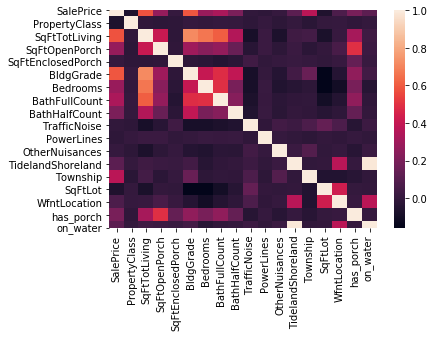

In [13]:
mc.corr_heatmap(df)

As we can see the features that seem to influence 'SalePrice' the most are home square footage, building grade which relates to the quality of the home, township which is the area the home is located, and the number of bedrooms and bathrooms in the home. In terms of the claims we are exploring, nuisances seem to have very little effect on home sale price. Waterfront homes seem to be a little more expensive as do homes with a porch of somekind. Knowing this information, we can proceed to creating our baseline model.

## Baseline Model

From the correlation plot above, we can see that the total square footage of a home strongly influences the sale price. This is a simple idea and since it has such a strong correlation, this is the feature we will use to create our baseline model.

In [12]:
model_df = df[['SalePrice', 'SqFtTotLiving']]
model_df = model_df[model_df['SalePrice'] < 2000000]
y = model_df.SalePrice #target
x = model_df.drop('SalePrice', axis=1) # features
model = mc.create_model(x, y)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                          1.557e+05
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                        0.00
Time:                        18:32:26   Log-Likelihood:                     -4.0446e+05
No. Observations:               28735   AIC:                                  8.089e+05
Df Residuals:                   28734   BIC:                                  8.089e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   319.1168      0.809    394.577      0.000     317.532     320.702
==============================================================================
Omnibus:                     3129.722   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27295.899
Skew:                          -0.140   Prob(JB):                         0.00
Kurtosis:                       7.766   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Utilizing the predefined function 'test_assumptions', we can check the assumptions of linear regression of this model to see how well it performed.

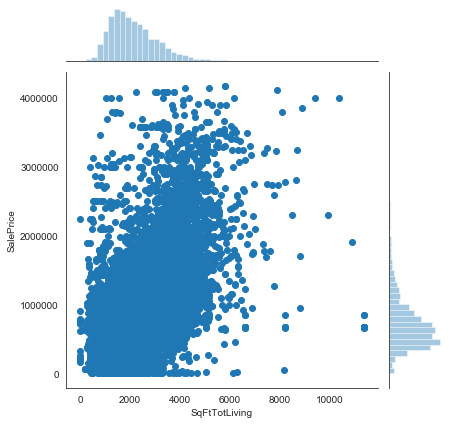

In [16]:
jw.sns.set_style('white')
jw.sns.jointplot(df['SqFtTotLiving'], df['SalePrice'])
jw.plt.savefig('../../report/figures/saleprice_totsqft_living.png', orientation='landscape', pad_inches=1)

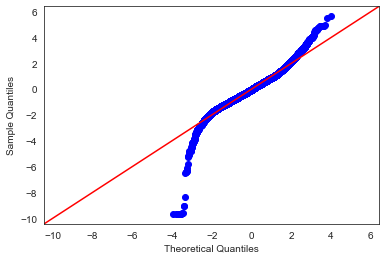

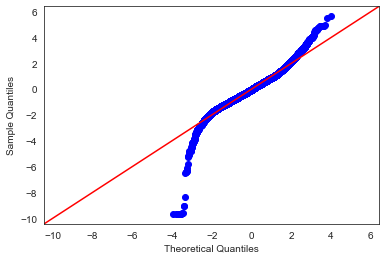

In [21]:
jw.sm.graphics.qqplot(model.resid, dist=jw.stats.norm, line='45', fit=True)

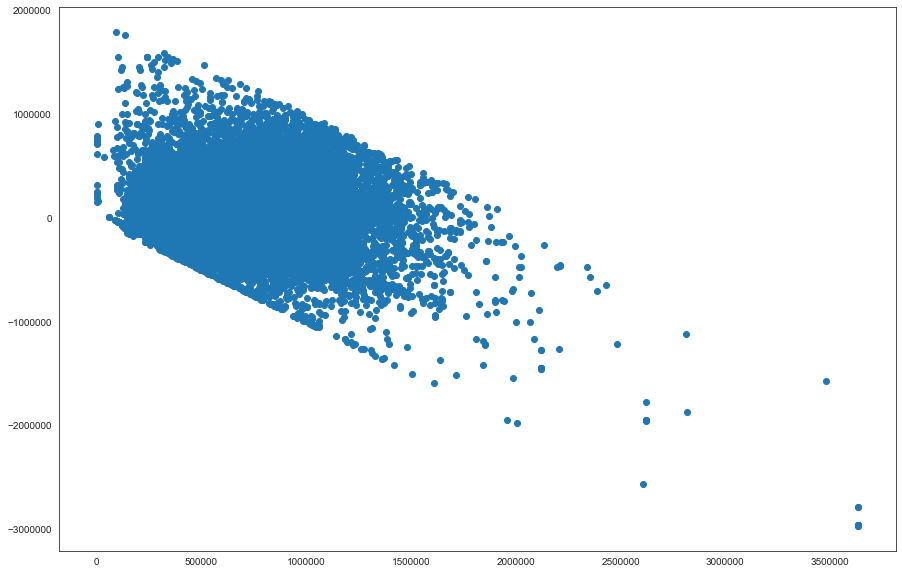

In [23]:
y_hat = model.predict()
fig, ax = jw.plt.subplots(figsize=(15,10))
ax.scatter(y_hat, model.resid)

In [28]:
jw.sm.stats.diagnostic.linear_rainbow(model)

(1.062097093793554, 0.00015295825912515923)

- We are failing to meet the linearity assumption, our linear rainbow p-value was below .05
- We are failing to meet the normality assumption, our JB score was 27,295
- We are failing to meet the homoscedasticity assumption, the data points are not randomly distributed.

### Model Iterations:
#### To start iterating over our baseline model we wanted to double check all of the possible variables. We started by imported a dataframe with every column and then created a correlation frame to see which variables had a high correlation to sale price. From there we chose to select the variables that were necessary to address our claims. We ended up sticking with the same variables that were used with the baseline model.

In [5]:
df = jw.create_dataframe()

We wanted to start with the same dataframe that was used for our baseline model before adding or removing any features. 

In [8]:
df.corr()['SalePrice'].sort_values(ascending=False)[:30]

SalePrice             1.000000
BldgGrade             0.246312
SqFtTotLiving         0.245807
NbrLivingUnits        0.183809
LakeWashington        0.180161
SqFt1stFloor          0.177734
SqFt2ndFloor          0.161102
HBUAsIfVacant         0.152119
BathFullCount         0.151338
TidelandShoreland     0.149521
SqFtOpenPorch         0.124655
Territorial           0.123391
SaleReason            0.121727
Bedrooms              0.120940
BldgGradeVar          0.118038
Stories               0.111256
SqFtGarageAttached    0.108975
SqFtFinBasement       0.089767
BathHalfCount         0.087803
Township              0.087469
WfntLocation          0.086750
has_porch             0.084885
SqFtTotBasement       0.079278
Bath3qtrCount         0.077968
SeattleSkyline        0.073274
Olympics              0.065150
FinBasementGrade      0.063306
LakeSammamish         0.062780
AddnlCost             0.062443
WfntBank              0.058735
Name: SalePrice, dtype: float64

In [9]:
model_df = df[['SalePrice',           
'BldgGrade',            
'SqFtTotLiving',        
'NbrLivingUnits',       
'LakeWashington',              
'BathFullCount',        
'TidelandShoreland',    
'SqFtOpenPorch',                  
'Bedrooms',                                          
'BathHalfCount',        
'Township',
'WfntLocation',
'has_porch',               
'PowerLines',
'TrafficNoise',
'OtherNuisances']]

In [14]:
# mean of sale price
mean_sale_price = model_df['SalePrice'].mean()
# Standard deviation of sale price
std_sale_price = model_df['SalePrice'].std()

In [15]:
z_scores = [mc.z_score(p, mean_sale_price, std_sale_price)
            for p in model_df['SalePrice']]

In [17]:
outliers = [False if ((z < -1) | (z > 1)) else True for z in z_scores]
outliers
test_df = model_df[outliers]

In [20]:
test_df['SalePrice'].max()

2198999

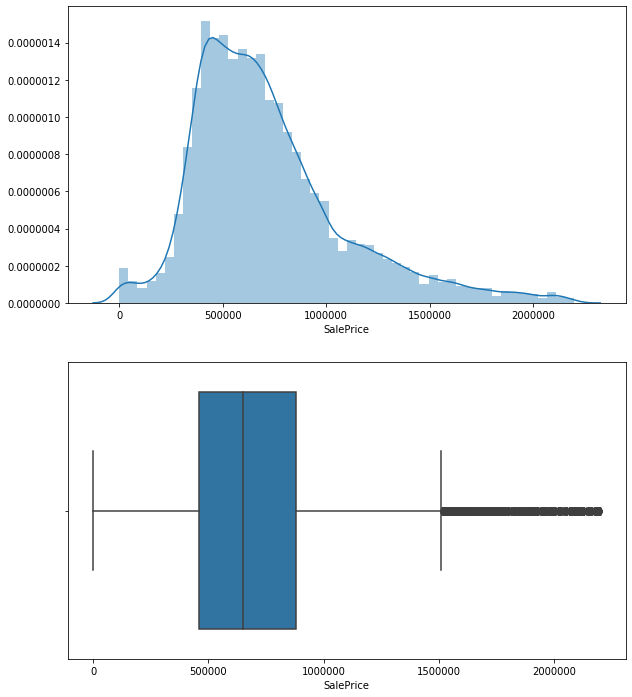

In [31]:
mc.plot_dist(test_df['SalePrice'])

#### Looking at the distribution here, we still have a few outliers that are keeping the distribution from being normal. I am going to check how many records there are and see if we can remove them.

In [38]:
sum(model_df['SalePrice']<150000)

3390

In [39]:
sum(model_df['SalePrice'] > 1300000)

3390

#### There are 538 records with a sale price below 150 thousand and 3390 records with a sale price above 1.3 million. I am going to remove these for now to try and normalize the distribution.

In [40]:
model_df = model_df[model_df['SalePrice'] > 150000]

In [41]:
model_df = model_df[model_df['SalePrice'] < 1300000]

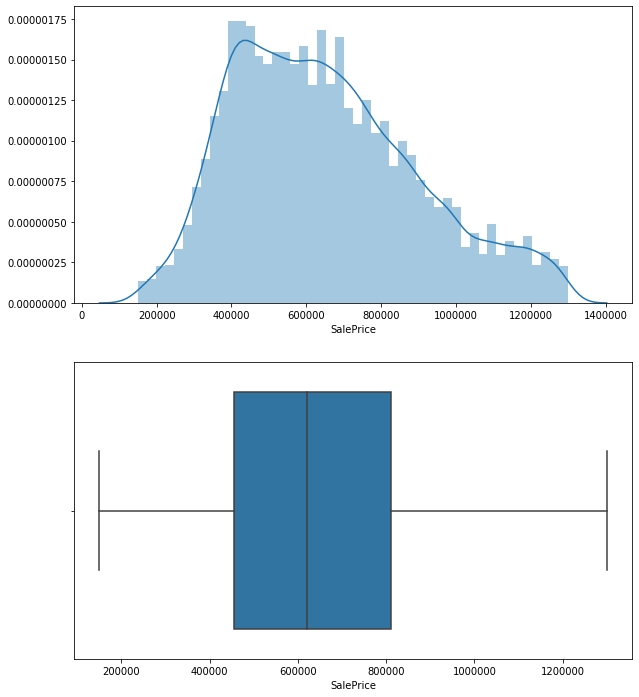

In [42]:
mc.plot_dist(model_df['SalePrice'])

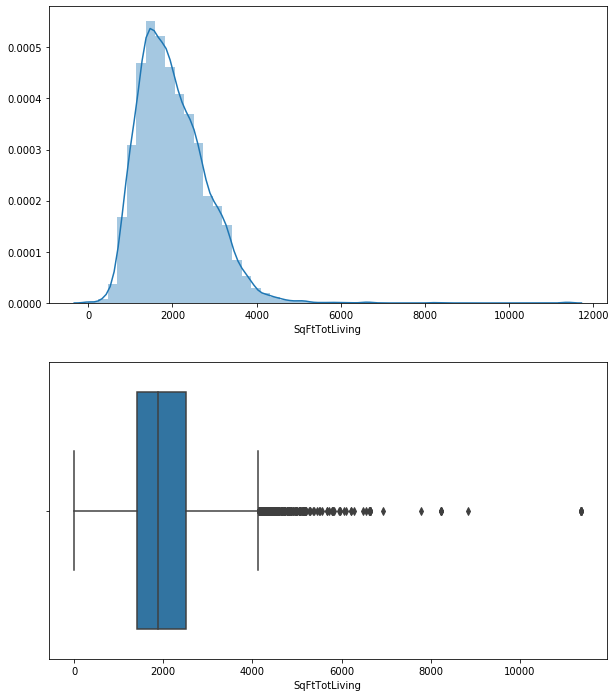

In [43]:
mc.plot_dist(model_df['SqFtTotLiving'])

In [45]:
sum(model_df['SqFtTotLiving'] > 4000)

354

#### There are a few outliers that in the total sqft of living column. In total, there are 354 records with the sqft of total living under 4000 square feet. I am going to remove these records for now.

In [46]:
model_df = model_df[model_df['SqFtTotLiving'] < 4000]

In [47]:
model_df.shape

(25568, 16)

#### This still leaves us with 25,568 records to work with in our model.

## Iteration 2

#### For the first iteration of our model we are going to add the building grade variable as a feature.

In [61]:
features = list(model2_df.drop('SalePrice', axis=1))

In [51]:
model2_df = model_df[['SalePrice', 'SqFtTotLiving', 'BldgGrade']]
formula = 'SalePrice~SqFtTotLiving+BldgGrade'
model2 = jw.smf.ols(formula=formula, data=model2_df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     5520.
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:39:33   Log-Likelihood:            -3.4900e+05
No. Observations:               25568   AIC:                         6.980e+05
Df Residuals:                   25565   BIC:                         6.980e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.199e+05   1.08e+04    -20.418      0.000   -2.41e+05   -1.99e+05
SqFtTotLiving    76.2834      2.262     33.719      0.000      71.849      80.718
BldgGrade      9.585e+04   1726.904     55.505      0.000    9.25e+04    9.92e+04
==============================================================================
Omnibus:                      899.393   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              996.071
Skew:                           0.477   Prob(JB):                    5.08e-217
Kurtosis:                       3.163   Cond. No.                     1.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Rainbow test statistic: 0.9667321676279542
Rainbow test p-value: 0.9720964245623701
JB test statistic: 996.071386431739
JB test p-value: 5.0798003713423046e-217
Breusch Pagan test statistic: 8211.94944007364
Breusch Pagan p-value: 0.0
VIF: 12.012775404661847


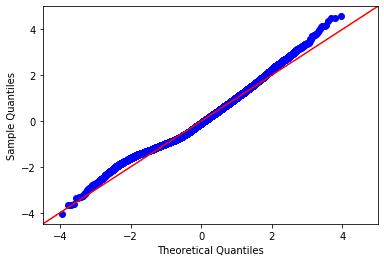

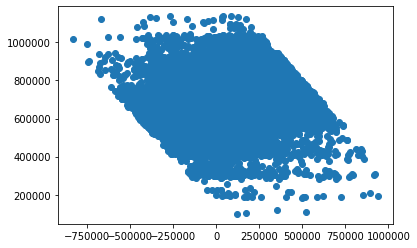

In [63]:
mc.test_assumptions(model2_df, model2, features)

With a pvalue of .97 we are currently meeting the linearity assumption. The normality assumption is still being violated as well as the homoscedasticity assumption. With our vif score of 12, we are violating the independence assumption.

#### Let's check for multicollinearity between the features we have chosen.

In [69]:
jw.multi_coll(model_df)[:15]

,corrcoeff
pairs,
"(SalePrice, SalePrice)",1.000000
"(Bedrooms, SqFtTotLiving)",0.651643
"(BldgGrade, SqFtTotLiving)",0.634667
"(has_porch, SqFtOpenPorch)",0.610387
"(SqFtTotLiving, BathFullCount)",0.548074
"(BldgGrade, SalePrice)",0.520143
"(SalePrice, Township)",0.513427
"(SalePrice, SqFtTotLiving)",0.466314
"(BathFullCount, Bedrooms)",0.427229


#### For the next model iteration we are going to try encoding the categorical variables in the dataframe and storing the results in a new dataframe, model_df_encoded.

In [70]:
model_df_encoded = jw.dummify(model_df, ['BldgGrade',
                                      'NbrLivingUnits',
                                      'LakeWashington',
                                      'BathFullCount',
                                      'TidelandShoreland',
                                      'BathHalfCount',
                                      'Township',
                                      'WfntLocation',
                                      'has_porch',
                                      'PowerLines',
                                      'TrafficNoise',
                                      'OtherNuisances'])

## Iteration 3

In [71]:
y = model_df_encoded['SalePrice']
X = model_df_encoded.drop(['SalePrice'], axis=1)
model3 = jw.sm.OLS(y, X).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.220e+04
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                        0.00
Time:                        17:05:14   Log-Likelihood:                     -3.3906e+05
No. Observations:               25568   AIC:                                  6.782e+05
Df Residuals:                   25518   BIC:                                  6.786e+05
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
SqFtTotLiving         134.2455      2.113     63.541      0.000     130.104     138.387
SqFtOpenPorch          84.5247     11.296      7.483      0.000      62.384     106.666
Bedrooms            -4970.9448   1323.173     -3.757      0.000   -7564.438   -2377.451
BldgGrade_4          1.088e+05   5.75e+04      1.891      0.059   -3945.653    2.22e+05
BldgGrade_5          5.372e+04   5.34e+04      1.006      0.314   -5.09e+04    1.58e+05
BldgGrade_6          1.435e+04   5.29e+04      0.271      0.786   -8.94e+04    1.18e+05
BldgGrade_7          5.233e+04   5.29e+04      0.988      0.323   -5.15e+04    1.56e+05
BldgGrade_8          1.033e+05    5.3e+04      1.949      0.051    -569.542    2.07e+05
BldgGrade_9          1.886e+05   5.31e+04      3.552      0.000    8.45e+04    2.93e+05
BldgGrade_10          2.45e+05   5.34e+04      4.587      0.000     1.4e+05     3.5e+05
BldgGrade_11         2.955e+05   5.81e+04      5.087      0.000    1.82e+05    4.09e+05
NbrLivingUnits_2     1.661e+04   8842.629      1.878      0.060    -721.492    3.39e+04
NbrLivingUnits_3     1.107e+04   1.86e+04      0.596      0.551   -2.53e+04    4.75e+04
LakeWashington_1     5.255e+04   1.26e+04      4.167      0.000    2.78e+04    7.73e+04
LakeWashington_2     7.952e+04   1.43e+04      5.572      0.000    5.16e+04    1.07e+05
LakeWashington_3     1.194e+05   1.87e+04      6.395      0.000    8.28e+04    1.56e+05
LakeWashington_4     1.371e+05   3.86e+04      3.548      0.000    6.14e+04    2.13e+05
BathFullCount_1       -66.1685   7056.469     -0.009      0.993   -1.39e+04    1.38e+04
BathFullCount_2     -1941.5760   7241.171     -0.268      0.789   -1.61e+04    1.23e+04
BathFullCount_3     -1589.5200   8162.693     -0.195      0.846   -1.76e+04    1.44e+04
BathFullCount_4     -1.227e+04   1.67e+04     -0.735      0.463    -4.5e+04    2.05e+04
BathFullCount_5      9.736e+04   9.87e+04      0.986      0.324   -9.61e+04    2.91e+05
TidelandShoreland_1   2.41e+05    1.4e+05      1.720      0.085   -3.36e+04    5.16e+05
TidelandShoreland_2  1.942e+05   1.52e+05      1.275      0.202   -1.04e+05    4.93e+05
TidelandShoreland_3 -3.783e+04   1.39e+05     -0.272      0.786   -3.11e+05    2.35e+05
BathHalfCount_1     -1.506e+04   1936.423     -7.776      0.000   -1.89e+04   -1.13e+04
BathHalfCount_2      7209.4371   1.11e+04      0.650      0.516   -1.45e+04     2.9e+04
BathHalfCount_3      6.868e+04   4.71e+04      1.458      0.145   -2.37e+04    1.61e+05
BathHalfCount_4     -5.206e+05    1.4e+05     -3.730      0.000   -7.94e+05   -2.47e+05
Township_20          1.196e+05   5.32e+04      2.247      0.025    1.53e+04    2.24e+05
Township_21          9.465e+04   5.29e+04      1.790      0.074   -9016.193    1

Rainbow test statistic: 0.9947772269984866
Rainbow test p-value: 0.6162978644655677
JB test statistic: 14827.065351013518
JB test p-value: 0.0
Breusch Pagan test statistic: 4992.224156752826
Breusch Pagan p-value: 0.0
VIF: 154.64477444487372


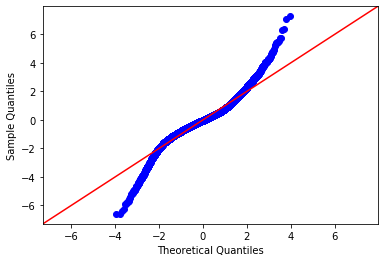

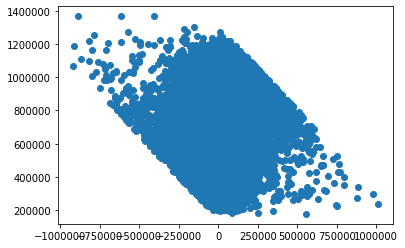

In [73]:
features = list(model_df_encoded.drop('SalePrice', axis=1))
mc.test_assumptions(model_df_encoded, model3, features)

#### Our rainbow test pvalue was .62, indicating we are meeting the linearity assumption. Our JB was 14,827.07, indicating we are failing to meet the normality assumption. Our Breush Pagan test stat was 4,992.22, indicating we are also failing to meet the homoscedasticity assumption. Our VIF of 154.644 shows we are also violating the independence assumption.

#### Let's check for multicollinearity between the features we have chosen.

In [74]:
jw.multi_coll(model_df_encoded)[:15]

,corrcoeff
pairs,
"(SalePrice, SalePrice)",1.000000
"(BathFullCount_2, BathFullCount_1)",0.853413
"(WfntLocation_3, TidelandShoreland_2)",0.851323
"(WfntLocation_6, LakeWashington_4)",0.659213
"(SqFtTotLiving, Bedrooms)",0.651643
"(SqFtOpenPorch, has_porch_1)",0.610387
"(BldgGrade_7, BldgGrade_8)",0.595427
"(BathFullCount_1, SqFtTotLiving)",0.485734
"(SalePrice, SqFtTotLiving)",0.466314


## Iteration 4

#### For this iteration I would like to remove the features that show strong multicollinearity. The function used to show multicollinearty returns variables that have show a multicollinearty greater than .2 and less than 1. I am going to remove 
- Full Bath Count's 1, 2, 3, and 5
- Half Bath Count 1, 3, and 4
- Building Grade's 4, 5, 6, 7, 8, and 9
- Waterfront Location's 1, 3, 4, and 5
- Lake Washington 4
- Tideland Shoreland 2 and 3
- Township's 21, 22, 24, 25
- Total Living sqft
- Bedrooms
- Open Porch sqft

In [113]:
new_model_df = model_df_encoded.drop(columns=['BathFullCount_1',
                       'BathFullCount_2',
                       'BathFullCount_3',
                       'BathHalfCount_1',
                       'BldgGrade_6',
                       'BldgGrade_7',
                       'BldgGrade_8',
                       'BldgGrade_9',
                       'WfntLocation_3',
                       'LakeWashington_4',
                       'TidelandShoreland_2',
                       'Township_21',
                       'Township_22',
                       'Township_24',
                       'Township_25',
                       'SqFtTotLiving',
                       'SqFtOpenPorch',
                       'Bedrooms',
                       'BldgGrade_4',
                       'BldgGrade_5',
                       'BathHalfCount_3',
                       'BathFullCount_5',
                       'TidelandShoreland_3',
                       'WfntLocation_1',
                       'WfntLocation_4',
                       'WfntLocation_5',
                       'BathHalfCount_4'], axis=1)                 

In [114]:
y = new_model_df['SalePrice']
X = new_model_df.drop(['SalePrice'], axis=1)
model4 = jw.sm.OLS(y, X).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.642
Model:                            OLS   Adj. R-squared (uncentered):              0.642
Method:                 Least Squares   F-statistic:                              1993.
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                        0.00
Time:                        18:12:17   Log-Likelihood:                     -3.6702e+05
No. Observations:               25568   AIC:                                  7.341e+05
Df Residuals:                   25545   BIC:                                  7.343e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
BldgGrade_10         4.874e+05    1.8e+04     27.005      0.000    4.52e+05    5.23e+05
BldgGrade_11         5.212e+05   7.03e+04      7.419      0.000    3.84e+05    6.59e+05
NbrLivingUnits_2     2.446e+05   2.59e+04      9.439      0.000    1.94e+05    2.95e+05
NbrLivingUnits_3     3.534e+05   5.37e+04      6.582      0.000    2.48e+05    4.59e+05
LakeWashington_1     3.138e+05   3.75e+04      8.361      0.000     2.4e+05    3.87e+05
LakeWashington_2      3.62e+05   4.25e+04      8.523      0.000    2.79e+05    4.45e+05
LakeWashington_3     2.707e+05   5.56e+04      4.866      0.000    1.62e+05     3.8e+05
BathFullCount_4      1.594e+05   4.45e+04      3.583      0.000    7.22e+04    2.47e+05
TidelandShoreland_1  3.635e+05   1.57e+05      2.314      0.021    5.57e+04    6.71e+05
BathHalfCount_2      2.174e+05   3.29e+04      6.615      0.000    1.53e+05    2.82e+05
Township_20          4.808e+04   1.95e+04      2.460      0.014    9774.357    8.64e+04
Township_23          2.113e+05   6818.686     30.991      0.000    1.98e+05    2.25e+05
Township_26          4.132e+05   6345.979     65.106      0.000    4.01e+05    4.26e+05
WfntLocation_6       3.314e+05   1.31e+05      2.523      0.012     7.4e+04    5.89e+05
WfntLocation_7       7.035e+05   2.94e+05      2.396      0.017    1.28e+05    1.28e+06
WfntLocation_8       3.343e+05   4.22e+04      7.924      0.000    2.52e+05    4.17e+05
WfntLocation_9       1.528e+05   4.84e+04      3.158      0.002     5.8e+04    2.48e+05
has_porch_1          5.169e+05   4103.212    125.969      0.000    5.09e+05    5.25e+05
PowerLines_Y         1.409e+05   2.56e+04      5.514      0.000    9.08e+04    1.91e+05
TrafficNoise_1       2.551e+05   9193.678     27.747      0.000    2.37e+05    2.73e+05
TrafficNoise_2       2.679e+05    1.2e+04     22.341      0.000    2.44e+05    2.91e+05
TrafficNoise_3       2.852e+05   2.95e+04      9.680      0.000    2.27e+05    3.43e+05
OtherNuisances_Y     2.409e+05   1.47e+04     16.420      0.000    2.12e+05     2.7e+05
==============================================================================
Omnibus:                       95.869   Durbin-Watson:                   1.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.618
Skew:                           0.141   Prob(JB):                     1.73e-21
Kurtosis:                       2.899   Cond. No.                         84.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rainbow test statistic: 1.0040602671788623
Rainbow test p-value: 0.4094584520205275
JB test statistic: 95.87354233066809
JB test p-value: 1.5181853721229675e-21
Breusch Pagan test statistic: 1943.5195735373645
Breusch Pagan p-value: 0.0
VIF: 0.6989291545047718


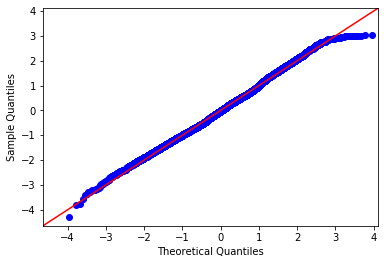

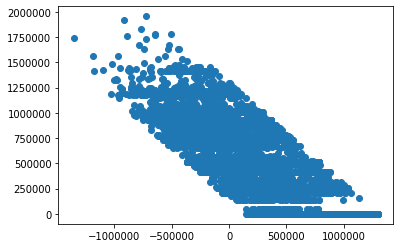

In [84]:
features = list(new_model_df.drop('SalePrice', axis=1))
mc.test_assumptions(new_model_df, model4, features)

## Assumption Check:
#### Our rainbow pvalue of .41 indicates we are meeting the linearity assumption.
#### Our JB score of 95.87 shows we are violating the normality assumption.
#### Our Breusch Pagan test statistic of 1943.52 shows we are not meeting the homoscedasticity assumption.
#### Our variation inflation factor of .7 shows we are meeting the independence assumption.


In [110]:
jw.multi_coll(new_model_df)[:15]

,corrcoeff
pairs,
"(SalePrice, SalePrice)",1.000000
"(SalePrice, BldgGrade_10)",0.214395
"(SalePrice, Township_23)",0.186509
"(SalePrice, has_porch_1)",0.166571
"(SalePrice, BldgGrade_5)",0.101826
"(Township_20, SalePrice)",0.101312
"(NbrLivingUnits_2, BathHalfCount_2)",0.084870
"(BldgGrade_10, has_porch_1)",0.070911
"(TrafficNoise_2, TrafficNoise_1)",0.068581


# Summary
###### Our final model has an R-Squared of .64 and a JB score of 95.87 while passing the linearity and independence assumptions. The variables we have ended up with do not show multicollinearity above (.25). The claims we chose to address were:
#### - 'Having a porch increases home sale price'
###### The p-value for the column 'has_porch' was 0, indicating that it was statistically significant for our model.
#### - 'Having a beachfront or lakefront increases home sale price'.
###### The p-value for the columns defining waterfront locations and tideland/shorelands are all below .05, making them statistically significant.
#### - 'The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price'
###### The p-value for the columns Power Lines, Traffic Noise, and Other Nuisances are all below .05, indicating they are statistically significant.